In [2]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [3]:
from includes import *

#################### "includes" imports:
#
#   from read_data import *
#   
#   import torch
#   from torch.autograd import Variable
#   import torch.nn as nn
#   import torch.optim as optim
#
#   dtype = torch.cuda.FloatTensor # torch.FloatTensor
#
#   all_files = [h5py.File(m, 'r') for m in mat_names]
#   all_ims = [f['image'] for f in all_files]
#   all_types = [f['type'] for f in all_files]
#
####################
%load_ext autoreload
%autoreload 2

In [4]:
image_mat = all_ims[0]
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [5]:
print(mat_names)

['./project_datasets/A01T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A09T_slice.mat']


In [6]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [7]:
type_mat = all_types[0]
type_shape = type_mat.shape
type_set = list(set(type_mat[0,:]))

# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

In [8]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [9]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [10]:
from functools import reduce

rnn_trainval_data_X = np.concatenate(trainval_data_X, axis=0) #(2142, 22, 1000)
rnn_training_data_X = np.concatenate(training_data_X, axis=0) #(1800, 22, 1000)
rnn_validation_data_X = np.concatenate(validation_data_X, axis=0) #(342, 22, 1000)
rnn_test_data_X = np.concatenate(test_data_X, axis=0) #(450, 22, 1000)

rnn_trainval_data_Y = np.concatenate(trainval_data_Y, axis=0) #(2142, )
rnn_training_data_Y = np.concatenate(training_data_Y, axis=0) #(1800, )
rnn_validation_data_Y = np.concatenate(validation_data_Y, axis=0) #(342, )
rnn_test_data_Y = np.concatenate(test_data_Y, axis=0) #(450,)

def remove_nan_rows_A(A, b, debug=True):
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
    
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    assert A.shape[0] == b.shape[0]
    return A, b

rnn_trainval_data_X, rnn_trainval_data_Y = remove_nan_rows_A(rnn_trainval_data_X,
                                                             rnn_trainval_data_Y)
rnn_training_data_X, rnn_training_data_Y = remove_nan_rows_A(rnn_training_data_X, 
                                                             rnn_training_data_Y)
rnn_validation_data_X, rnn_validation_data_Y = remove_nan_rows_A(rnn_validation_data_X,
                                         rnn_validation_data_Y)
rnn_test_data_X, rnn_test_data_Y = remove_nan_rows_A(rnn_test_data_X,
                                   rnn_test_data_Y)

N_trainval, E, T = rnn_trainval_data_X.shape
N_training, _, _ = rnn_trainval_data_X.shape
N_validation, _, _ = rnn_test_data_X.shape
N_test, _, _ = rnn_test_data_X.shape

before nans: (2142, 22, 1000)
before nans: (2115, 22, 1000)
before nans: (1800, 22, 1000)
before nans: (1775, 22, 1000)
before nans: (342, 22, 1000)
before nans: (340, 22, 1000)
before nans: (450, 22, 1000)
before nans: (443, 22, 1000)


In [11]:
print(training_data_Y[0].shape)

(200,)


In [12]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [13]:
print rnn_trainval_data_X.shape
print rnn_trainval_data_Y.shape

(2115, 22, 1000)
(2115,)


In [14]:
from torch.nn.utils.rnn import pack_padded_sequence as ppseq

In [15]:
tensor_x_train = torch.Tensor(rnn_training_data_X)
tensor_y_train = torch.LongTensor(rnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

tensor_x_val = torch.Tensor(rnn_validation_data_X)
tensor_y_val = torch.LongTensor(rnn_validation_data_Y)

torch.Size([1775, 22, 1000])
torch.Size([1775])


In [16]:
import torch.utils.data

In [17]:
# Dataset Hyper Parameters
num_epochs = 20
batch_size = 100

In [18]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val,tensor_y_val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [25]:
# Optimizer Hyper Parameters
learning_rate = 1e-3
reg_hidden_weight = 1.0
reg_weight_size = 0.01
NUM_CLASSES = 4

# Debug Parameters
VERBOSE = False
PRINT_GRADS = False

from VanillaRNN import VanillaRNN

net = VanillaRNN(
                conv_layers = True,
                initial_hidden_layer_sizes = [],#[100],#[100],
                recurrent_hidden_size = 64,
                recurrent_use_bias = True,
                recurrent_layer_num = 2,
                #recurrent_dropout = 0.25,
                final_hidden_layer_sizes = [],#[100, 10],
                num_classes=NUM_CLASSES,
                verbose = VERBOSE)

FCC_SANITY = False

#from FC import FC
#net = FC()
#FCC_SANITY = True

net.initialize_weights()

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.01)


#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)


for s in net.parameters():
    print('{}'.format(s.shape))
    

torch.Size([22])
torch.Size([22])
torch.Size([16, 22, 25])
torch.Size([16])
torch.Size([8, 16, 25])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([64, 8])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64])
torch.Size([128])
torch.Size([128])
torch.Size([4, 128])
torch.Size([4])


torch.Size([1775, 4])


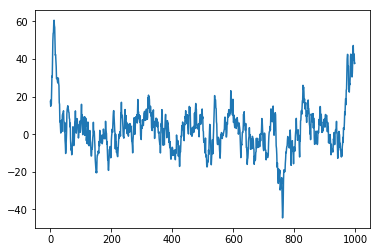

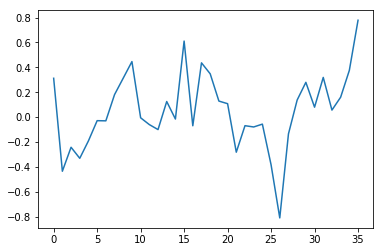

torch.Size([1775, 64])


In [20]:
net.train(True)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:
    out, hidden = net.forward(tensor_x_train)
print(out.shape)
net.train(False)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:    
    out, hidden = net.forward(tensor_x_train)
    
print(net.rnn_out.shape)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:65: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/20], Iter [1/17] Loss: [----- 1.8326 = 1.4545 + 1.00 * 0.0000 + 0.01 * 37.8013 -----]
Epoch [1/20], Iter [2/17] Loss: [----- 1.7616 = 1.3835 + 1.00 * 0.0005 + 0.01 * 37.7678 -----]
Epoch [1/20], Iter [3/17] Loss: [----- 1.8011 = 1.4123 + 1.00 * 0.0115 + 0.01 * 37.7384 -----]
Epoch [1/20], Iter [4/17] Loss: [----- 1.8235 = 1.4134 + 1.00 * 0.0331 + 0.01 * 37.7091 -----]
Epoch [1/20], Iter [5/17] Loss: [----- 1.7822 = 1.3971 + 1.00 * 0.0083 + 0.01 * 37.6813 -----]
Epoch [1/20], Iter [6/17] Loss: [----- 1.8421 = 1.3961 + 1.00 * 0.0694 + 0.01 * 37.6552 -----]
Epoch [1/20], Iter [7/17] Loss: [----- 1.7595 = 1.3827 + 1.00 * 0.0004 + 0.01 * 37.6314 -----]
Epoch [1/20], Iter [8/17] Loss: [----- 1.7348 = 1.3557 + 1.00 * 0.0030 + 0.01 * 37.6074 -----]
Epoch [1/20], Iter [9/17] Loss: [----- 2.1819 = 1.4103 + 1.00 * 0.3958 + 0.01 * 37.5823 -----]
Epoch [1/20], Iter [10/17] Loss: [----- 2.6868 = 1.4210 + 1.00 * 0.8902 + 0.01 * 37.5556 -----]
Epoch [1/20], Iter [11/17] Loss: [----- 1.8546 = 

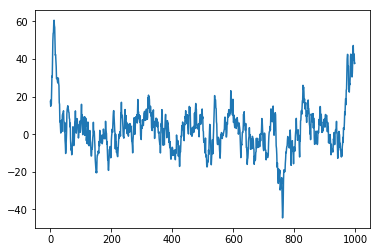

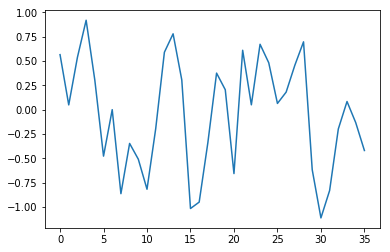

torch.Size([1775, 4])
Train Accuracy: 27 %


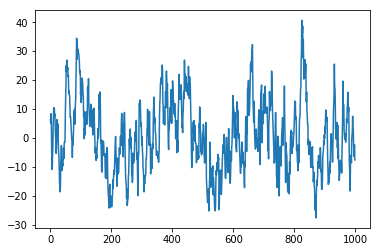

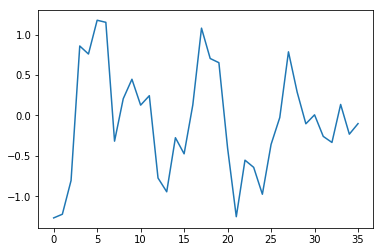

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 26 %
Epoch [2/20], Iter [1/17] Loss: [----- 1.7888 = 1.3651 + 1.00 * 0.0506 + 0.01 * 37.3122 -----]
Epoch [2/20], Iter [2/17] Loss: [----- 1.8808 = 1.3824 + 1.00 * 0.1255 + 0.01 * 37.2829 -----]
Epoch [2/20], Iter [3/17] Loss: [----- 2.1242 = 1.3954 + 1.00 * 0.3562 + 0.01 * 37.2528 -----]
Epoch [2/20], Iter [4/17] Loss: [----- 2.1550 = 1.3640 + 1.00 * 0.4188 + 0.01 * 37.2220 -----]
Epoch [2/20], Iter [5/17] Loss: [----- 1.8088 = 1.3774 + 1.00 * 0.0596 + 0.01 * 37.1924 -----]
Epoch [2/20], Iter [6/17] Loss: [----- 1.8833 = 1.3808 + 1.00 * 0.1309 + 0.01 * 37.1629 -----]
Epoch [2/20], Iter [7/17] Loss: [----- 2.0302 = 1.3963 + 1.00 * 0.2627 + 0.01 * 37.1334 -----]
Epoch [2/20], Iter [8/17] Loss: [----- 2.5701 = 1.3768 + 1.00 * 0.8223 + 0.01 * 37.1029 -----]
Epoch [2/20], Iter [9/17] Loss: [----- 2.4092 = 1.3818 + 1.00 * 0.6567 + 0.01 * 37.0719 -----]
Epoch [2/20], Iter [10/17] Loss: [----- 1.8068 = 1.3892 + 1.00 * 0.0472 + 0

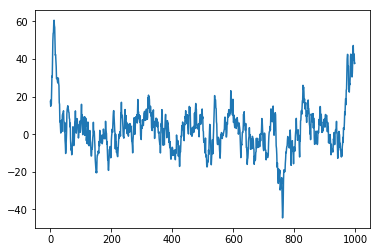

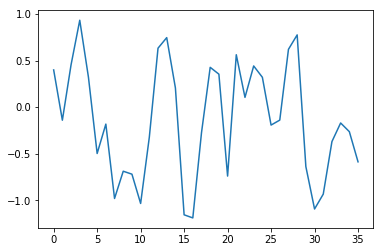

torch.Size([1775, 4])
Train Accuracy: 31 %


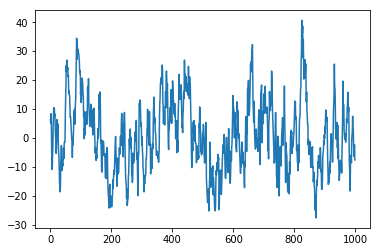

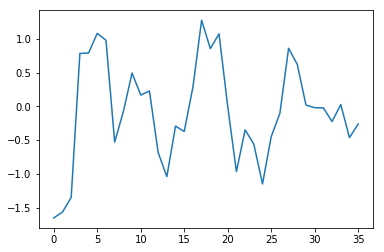

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 29 %
Epoch [3/20], Iter [1/17] Loss: [----- 1.8588 = 1.3684 + 1.00 * 0.1228 + 0.01 * 36.7559 -----]
Epoch [3/20], Iter [2/17] Loss: [----- 2.3657 = 1.3566 + 1.00 * 0.6419 + 0.01 * 36.7236 -----]
Epoch [3/20], Iter [3/17] Loss: [----- 2.0895 = 1.3551 + 1.00 * 0.3675 + 0.01 * 36.6909 -----]
Epoch [3/20], Iter [4/17] Loss: [----- 1.9761 = 1.3683 + 1.00 * 0.2412 + 0.01 * 36.6591 -----]
Epoch [3/20], Iter [5/17] Loss: [----- 1.9001 = 1.3689 + 1.00 * 0.1649 + 0.01 * 36.6268 -----]
Epoch [3/20], Iter [6/17] Loss: [----- 1.9394 = 1.3841 + 1.00 * 0.1893 + 0.01 * 36.5955 -----]
Epoch [3/20], Iter [7/17] Loss: [----- 1.9782 = 1.3672 + 1.00 * 0.2453 + 0.01 * 36.5648 -----]
Epoch [3/20], Iter [8/17] Loss: [----- 1.8736 = 1.3656 + 1.00 * 0.1427 + 0.01 * 36.5348 -----]
Epoch [3/20], Iter [9/17] Loss: [----- 2.0909 = 1.3598 + 1.00 * 0.3660 + 0.01 * 36.5048 -----]
Epoch [3/20], Iter [10/17] Loss: [----- 5.9808 = 1.3705 + 1.00 * 4.2455 + 0

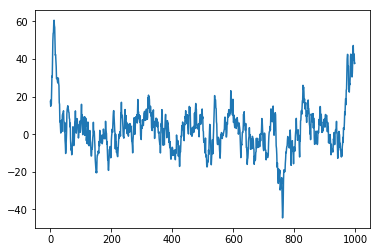

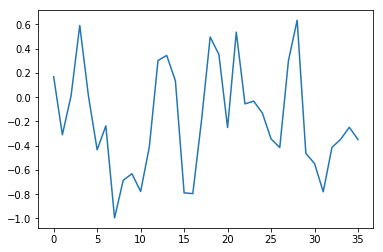

torch.Size([1775, 4])
Train Accuracy: 31 %


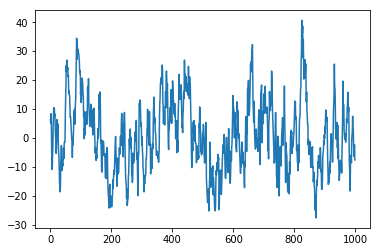

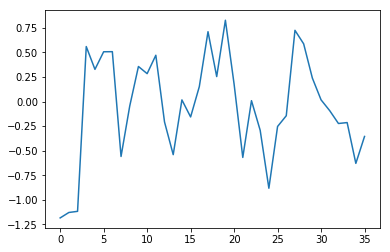

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [4/20], Iter [1/17] Loss: [----- 2.0813 = 1.3471 + 1.00 * 0.3723 + 0.01 * 36.1978 -----]
Epoch [4/20], Iter [2/17] Loss: [----- 2.5148 = 1.3464 + 1.00 * 0.8067 + 0.01 * 36.1656 -----]
Epoch [4/20], Iter [3/17] Loss: [----- 1.8236 = 1.3458 + 1.00 * 0.1165 + 0.01 * 36.1333 -----]
Epoch [4/20], Iter [4/17] Loss: [----- 2.8876 = 1.3743 + 1.00 * 1.1523 + 0.01 * 36.1021 -----]
Epoch [4/20], Iter [5/17] Loss: [----- 8.5019 = 1.3425 + 1.00 * 6.7987 + 0.01 * 36.0715 -----]
Epoch [4/20], Iter [6/17] Loss: [----- 5.2466 = 1.3774 + 1.00 * 3.5088 + 0.01 * 36.0406 -----]
Epoch [4/20], Iter [7/17] Loss: [----- 2.3887 = 1.3746 + 1.00 * 0.6540 + 0.01 * 36.0091 -----]
Epoch [4/20], Iter [8/17] Loss: [----- 2.4166 = 1.3465 + 1.00 * 0.7103 + 0.01 * 35.9773 -----]
Epoch [4/20], Iter [9/17] Loss: [----- 1.8854 = 1.3373 + 1.00 * 0.1887 + 0.01 * 35.9450 -----]
Epoch [4/20], Iter [10/17] Loss: [----- 2.7158 = 1.3256 + 1.00 * 1.0311 + 0

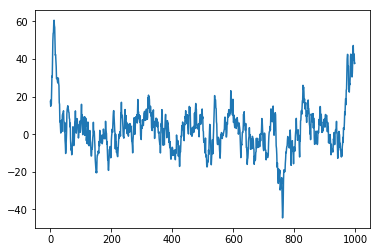

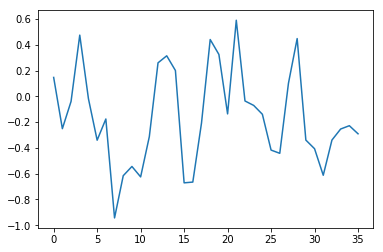

torch.Size([1775, 4])
Train Accuracy: 33 %


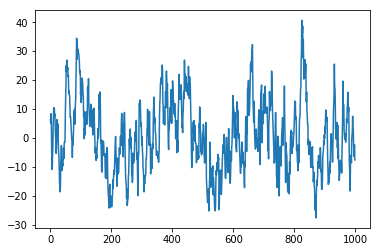

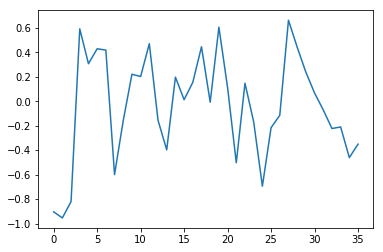

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 31 %
Epoch [5/20], Iter [1/17] Loss: [----- 2.6553 = 1.3467 + 1.00 * 0.9524 + 0.01 * 35.6176 -----]
Epoch [5/20], Iter [2/17] Loss: [----- 3.4705 = 1.3365 + 1.00 * 1.7782 + 0.01 * 35.5872 -----]
Epoch [5/20], Iter [3/17] Loss: [----- 45.6484 = 1.3192 + 1.00 * 43.9736 + 0.01 * 35.5561 -----]
Epoch [5/20], Iter [4/17] Loss: [----- 2.2522 = 1.3527 + 1.00 * 0.5443 + 0.01 * 35.5244 -----]
Epoch [5/20], Iter [5/17] Loss: [----- 2.0449 = 1.3480 + 1.00 * 0.3421 + 0.01 * 35.4923 -----]
Epoch [5/20], Iter [6/17] Loss: [----- 2.3474 = 1.3532 + 1.00 * 0.6396 + 0.01 * 35.4611 -----]
Epoch [5/20], Iter [7/17] Loss: [----- 1.8245 = 1.3392 + 1.00 * 0.1310 + 0.01 * 35.4298 -----]
Epoch [5/20], Iter [8/17] Loss: [----- 2.4797 = 1.3450 + 1.00 * 0.7807 + 0.01 * 35.3994 -----]
Epoch [5/20], Iter [9/17] Loss: [----- 2.0937 = 1.3535 + 1.00 * 0.3865 + 0.01 * 35.3686 -----]
Epoch [5/20], Iter [10/17] Loss: [----- 4.7839 = 1.4032 + 1.00 * 3.0273 +

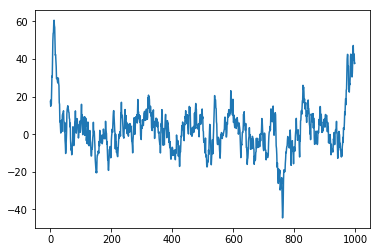

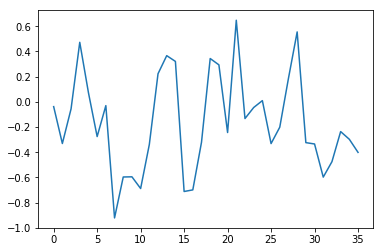

torch.Size([1775, 4])
Train Accuracy: 34 %


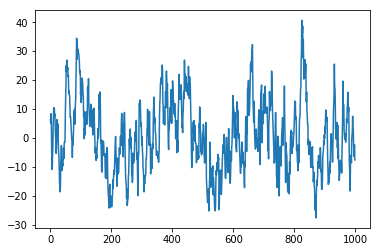

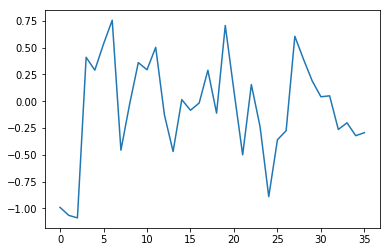

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 33 %
Epoch [6/20], Iter [1/17] Loss: [----- 14.0519 = 1.3551 + 1.00 * 12.3463 + 0.01 * 35.0588 -----]
Epoch [6/20], Iter [2/17] Loss: [----- 2.3606 = 1.3883 + 1.00 * 0.6220 + 0.01 * 35.0274 -----]
Epoch [6/20], Iter [3/17] Loss: [----- 1.7626 = 1.3215 + 1.00 * 0.0910 + 0.01 * 34.9966 -----]
Epoch [6/20], Iter [4/17] Loss: [----- 1.8541 = 1.2971 + 1.00 * 0.2074 + 0.01 * 34.9654 -----]
Epoch [6/20], Iter [5/17] Loss: [----- 3.0654 = 1.3064 + 1.00 * 1.4096 + 0.01 * 34.9344 -----]
Epoch [6/20], Iter [6/17] Loss: [----- 2.7142 = 1.3372 + 1.00 * 1.0280 + 0.01 * 34.9035 -----]
Epoch [6/20], Iter [7/17] Loss: [----- 2.9065 = 1.3395 + 1.00 * 1.2183 + 0.01 * 34.8722 -----]
Epoch [6/20], Iter [8/17] Loss: [----- 1.7877 = 1.3681 + 1.00 * 0.0713 + 0.01 * 34.8410 -----]
Epoch [6/20], Iter [9/17] Loss: [----- 2.5060 = 1.3406 + 1.00 * 0.8173 + 0.01 * 34.8107 -----]
Epoch [6/20], Iter [10/17] Loss: [----- 1.9574 = 1.2987 + 1.00 * 0.3109 +

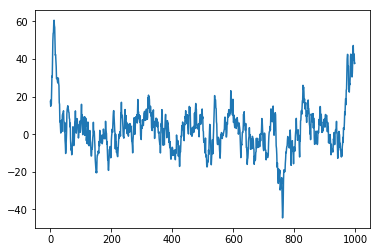

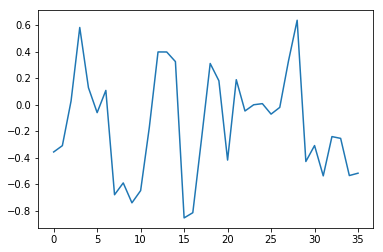

torch.Size([1775, 4])
Train Accuracy: 34 %


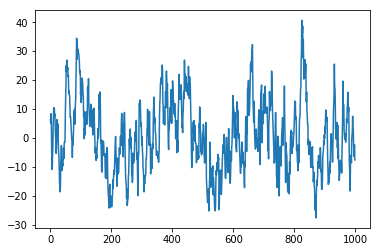

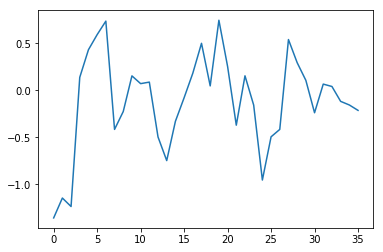

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 31 %
Epoch [7/20], Iter [1/17] Loss: [----- 2.4653 = 1.3436 + 1.00 * 0.7764 + 0.01 * 34.5307 -----]
Epoch [7/20], Iter [2/17] Loss: [----- 1.8599 = 1.3682 + 1.00 * 0.1468 + 0.01 * 34.5027 -----]
Epoch [7/20], Iter [3/17] Loss: [----- 2.5492 = 1.3010 + 1.00 * 0.9035 + 0.01 * 34.4738 -----]
Epoch [7/20], Iter [4/17] Loss: [----- 3.7608 = 1.3022 + 1.00 * 2.1142 + 0.01 * 34.4463 -----]
Epoch [7/20], Iter [5/17] Loss: [----- 1.9321 = 1.3285 + 1.00 * 0.2594 + 0.01 * 34.4183 -----]
Epoch [7/20], Iter [6/17] Loss: [----- 2.8009 = 1.2885 + 1.00 * 1.1684 + 0.01 * 34.3898 -----]
Epoch [7/20], Iter [7/17] Loss: [----- 1.8272 = 1.3806 + 1.00 * 0.1030 + 0.01 * 34.3625 -----]
Epoch [7/20], Iter [8/17] Loss: [----- 2.5247 = 1.3782 + 1.00 * 0.8031 + 0.01 * 34.3348 -----]
Epoch [7/20], Iter [9/17] Loss: [----- 2.3002 = 1.2914 + 1.00 * 0.6657 + 0.01 * 34.3077 -----]
Epoch [7/20], Iter [10/17] Loss: [----- 2.3669 = 1.3313 + 1.00 * 0.6928 + 0

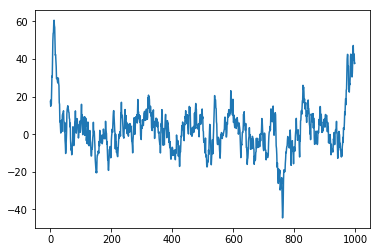

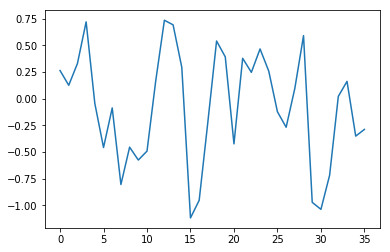

torch.Size([1775, 4])
Train Accuracy: 37 %


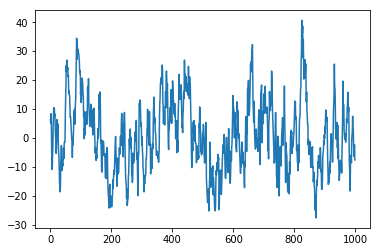

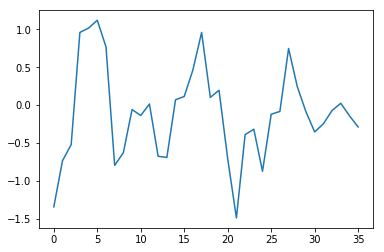

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 33 %
Epoch [8/20], Iter [1/17] Loss: [----- 1.8350 = 1.2712 + 1.00 * 0.2234 + 0.01 * 34.0402 -----]
Epoch [8/20], Iter [2/17] Loss: [----- 1.7351 = 1.2758 + 1.00 * 0.1191 + 0.01 * 34.0151 -----]
Epoch [8/20], Iter [3/17] Loss: [----- 2.2674 = 1.2591 + 1.00 * 0.6684 + 0.01 * 33.9902 -----]
Epoch [8/20], Iter [4/17] Loss: [----- 4.3992 = 1.2836 + 1.00 * 2.7759 + 0.01 * 33.9654 -----]
Epoch [8/20], Iter [5/17] Loss: [----- 2.5563 = 1.2830 + 1.00 * 0.9339 + 0.01 * 33.9404 -----]
Epoch [8/20], Iter [6/17] Loss: [----- 6.5011 = 1.3037 + 1.00 * 4.8582 + 0.01 * 33.9159 -----]
Epoch [8/20], Iter [7/17] Loss: [----- 1.9409 = 1.3654 + 1.00 * 0.2367 + 0.01 * 33.8909 -----]
Epoch [8/20], Iter [8/17] Loss: [----- 2.0188 = 1.3354 + 1.00 * 0.3448 + 0.01 * 33.8665 -----]
Epoch [8/20], Iter [9/17] Loss: [----- 1.9745 = 1.2962 + 1.00 * 0.3398 + 0.01 * 33.8420 -----]
Epoch [8/20], Iter [10/17] Loss: [----- 1.9166 = 1.3039 + 1.00 * 0.2744 + 0

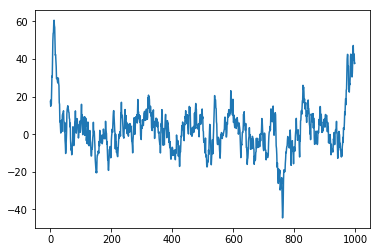

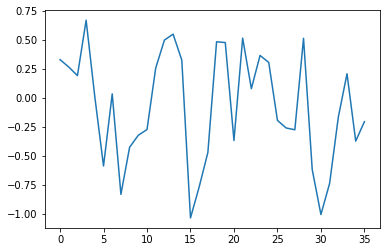

torch.Size([1775, 4])
Train Accuracy: 35 %


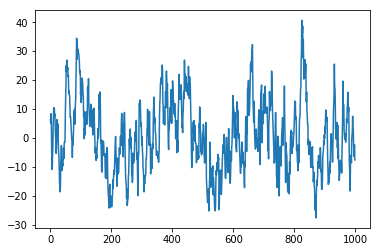

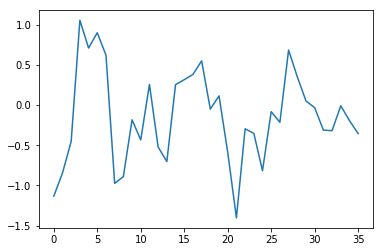

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [9/20], Iter [1/17] Loss: [----- 3.2498 = 1.2707 + 1.00 * 1.6431 + 0.01 * 33.6089 -----]
Epoch [9/20], Iter [2/17] Loss: [----- 2.1849 = 1.2195 + 1.00 * 0.6295 + 0.01 * 33.5873 -----]
Epoch [9/20], Iter [3/17] Loss: [----- 1.7063 = 1.3431 + 1.00 * 0.0276 + 0.01 * 33.5662 -----]
Epoch [9/20], Iter [4/17] Loss: [----- 4.3267 = 1.2860 + 1.00 * 2.7052 + 0.01 * 33.5453 -----]
Epoch [9/20], Iter [5/17] Loss: [----- 1.9843 = 1.2516 + 1.00 * 0.3975 + 0.01 * 33.5245 -----]
Epoch [9/20], Iter [6/17] Loss: [----- 3.9933 = 1.2500 + 1.00 * 2.4082 + 0.01 * 33.5037 -----]
Epoch [9/20], Iter [7/17] Loss: [----- 2.0033 = 1.3357 + 1.00 * 0.3328 + 0.01 * 33.4826 -----]
Epoch [9/20], Iter [8/17] Loss: [----- 1.9529 = 1.2802 + 1.00 * 0.3381 + 0.01 * 33.4608 -----]
Epoch [9/20], Iter [9/17] Loss: [----- 2.0064 = 1.2963 + 1.00 * 0.3758 + 0.01 * 33.4395 -----]
Epoch [9/20], Iter [10/17] Loss: [----- 2.9334 = 1.3649 + 1.00 * 1.2343 + 0

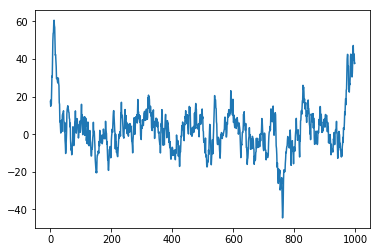

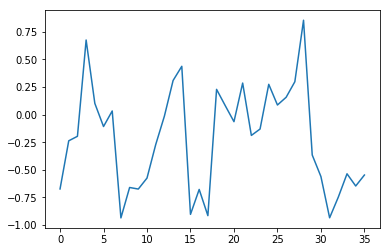

torch.Size([1775, 4])
Train Accuracy: 41 %


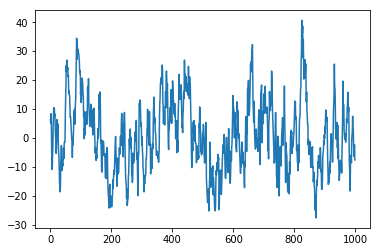

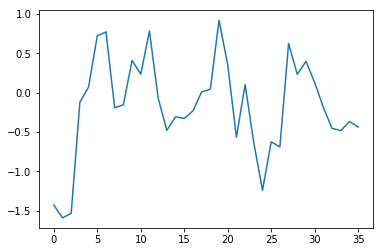

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 38 %
Epoch [10/20], Iter [1/17] Loss: [----- 1.8279 = 1.2700 + 1.00 * 0.2257 + 0.01 * 33.2181 -----]
Epoch [10/20], Iter [2/17] Loss: [----- 1.5845 = 1.1737 + 1.00 * 0.0787 + 0.01 * 33.1966 -----]
Epoch [10/20], Iter [3/17] Loss: [----- 2.6860 = 1.2544 + 1.00 * 1.0999 + 0.01 * 33.1769 -----]
Epoch [10/20], Iter [4/17] Loss: [----- 1.9148 = 1.2001 + 1.00 * 0.3831 + 0.01 * 33.1568 -----]
Epoch [10/20], Iter [5/17] Loss: [----- 2.6643 = 1.2261 + 1.00 * 1.1069 + 0.01 * 33.1360 -----]
Epoch [10/20], Iter [6/17] Loss: [----- 2.8373 = 1.2303 + 1.00 * 1.2759 + 0.01 * 33.1158 -----]
Epoch [10/20], Iter [7/17] Loss: [----- 1.8479 = 1.2529 + 1.00 * 0.2640 + 0.01 * 33.0951 -----]
Epoch [10/20], Iter [8/17] Loss: [----- 1.8593 = 1.2708 + 1.00 * 0.2578 + 0.01 * 33.0750 -----]
Epoch [10/20], Iter [9/17] Loss: [----- 1.7496 = 1.2714 + 1.00 * 0.1476 + 0.01 * 33.0544 -----]
Epoch [10/20], Iter [10/17] Loss: [----- 3.7683 = 1.2468 + 1.00 * 

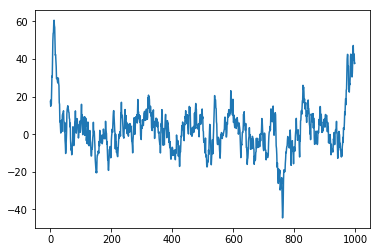

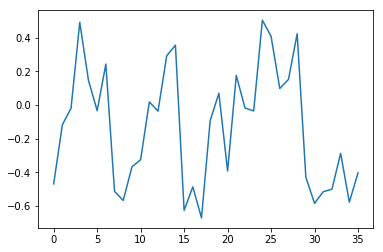

torch.Size([1775, 4])
Train Accuracy: 41 %


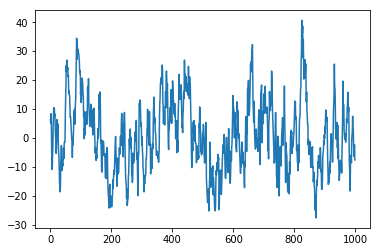

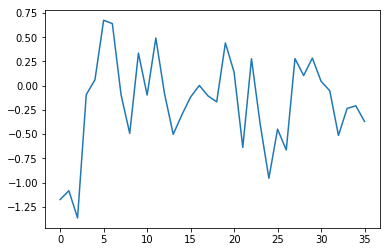

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 35 %
Epoch [11/20], Iter [1/17] Loss: [----- 1.6721 = 1.2637 + 1.00 * 0.0799 + 0.01 * 32.8548 -----]
Epoch [11/20], Iter [2/17] Loss: [----- 2.6051 = 1.2673 + 1.00 * 1.0094 + 0.01 * 32.8334 -----]
Epoch [11/20], Iter [3/17] Loss: [----- 2.0279 = 1.2328 + 1.00 * 0.4669 + 0.01 * 32.8119 -----]
Epoch [11/20], Iter [4/17] Loss: [----- 3.9496 = 1.2347 + 1.00 * 2.3870 + 0.01 * 32.7915 -----]
Epoch [11/20], Iter [5/17] Loss: [----- 2.5752 = 1.2682 + 1.00 * 0.9793 + 0.01 * 32.7706 -----]
Epoch [11/20], Iter [6/17] Loss: [----- 1.7394 = 1.2801 + 1.00 * 0.1317 + 0.01 * 32.7507 -----]
Epoch [11/20], Iter [7/17] Loss: [----- 3.5237 = 1.2239 + 1.00 * 1.9725 + 0.01 * 32.7301 -----]
Epoch [11/20], Iter [8/17] Loss: [----- 1.5670 = 1.1765 + 1.00 * 0.0634 + 0.01 * 32.7093 -----]
Epoch [11/20], Iter [9/17] Loss: [----- 1.7006 = 1.2737 + 1.00 * 0.1000 + 0.01 * 32.6907 -----]
Epoch [11/20], Iter [10/17] Loss: [----- 1.7127 = 1.2340 + 1.00 * 

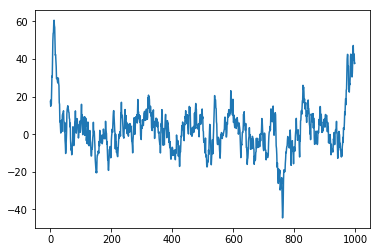

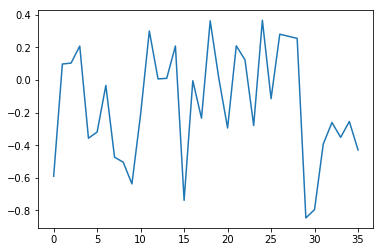

torch.Size([1775, 4])
Train Accuracy: 39 %


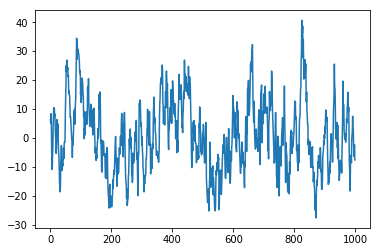

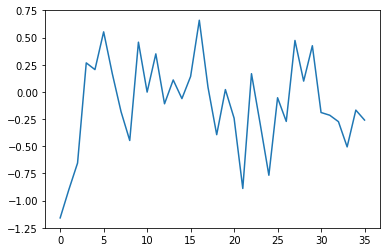

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 32 %
Epoch [12/20], Iter [1/17] Loss: [----- 6.2251 = 1.2482 + 1.00 * 4.6518 + 0.01 * 32.5122 -----]
Epoch [12/20], Iter [2/17] Loss: [----- 2.8542 = 1.2076 + 1.00 * 1.3216 + 0.01 * 32.4929 -----]
Epoch [12/20], Iter [3/17] Loss: [----- 3.0269 = 1.2462 + 1.00 * 1.4559 + 0.01 * 32.4735 -----]
Epoch [12/20], Iter [4/17] Loss: [----- 4.5718 = 1.2037 + 1.00 * 3.0436 + 0.01 * 32.4535 -----]
Epoch [12/20], Iter [5/17] Loss: [----- 2.9925 = 1.2597 + 1.00 * 1.4085 + 0.01 * 32.4330 -----]
Epoch [12/20], Iter [6/17] Loss: [----- 1.8793 = 1.2034 + 1.00 * 0.3518 + 0.01 * 32.4117 -----]
Epoch [12/20], Iter [7/17] Loss: [----- 2.7760 = 1.2631 + 1.00 * 1.1890 + 0.01 * 32.3921 -----]
Epoch [12/20], Iter [8/17] Loss: [----- 1.6854 = 1.2836 + 1.00 * 0.0780 + 0.01 * 32.3723 -----]
Epoch [12/20], Iter [9/17] Loss: [----- 2.1341 = 1.1841 + 1.00 * 0.6265 + 0.01 * 32.3512 -----]
Epoch [12/20], Iter [10/17] Loss: [----- 2.9543 = 1.2279 + 1.00 * 

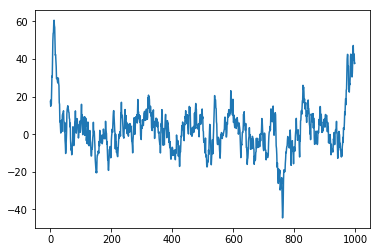

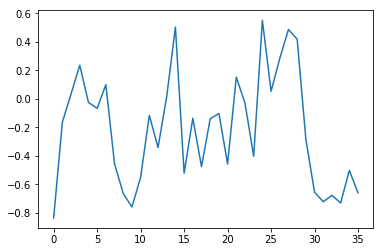

torch.Size([1775, 4])
Train Accuracy: 43 %


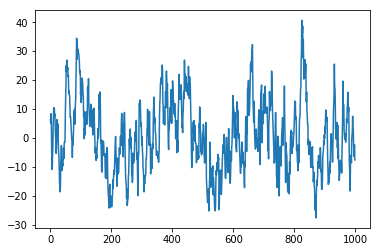

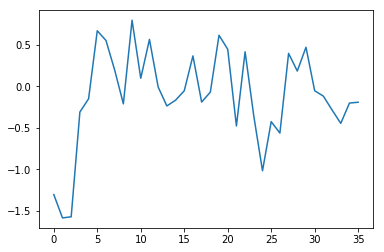

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 35 %
Epoch [13/20], Iter [1/17] Loss: [----- 3.1549 = 1.1997 + 1.00 * 1.6336 + 0.01 * 32.1598 -----]
Epoch [13/20], Iter [2/17] Loss: [----- 1.8683 = 1.2097 + 1.00 * 0.3372 + 0.01 * 32.1408 -----]
Epoch [13/20], Iter [3/17] Loss: [----- 2.5195 = 1.1792 + 1.00 * 1.0191 + 0.01 * 32.1220 -----]
Epoch [13/20], Iter [4/17] Loss: [----- 2.8350 = 1.2528 + 1.00 * 1.2612 + 0.01 * 32.1058 -----]
Epoch [13/20], Iter [5/17] Loss: [----- 4.1197 = 1.1830 + 1.00 * 2.6158 + 0.01 * 32.0904 -----]
Epoch [13/20], Iter [6/17] Loss: [----- 8.7101 = 1.2062 + 1.00 * 7.1832 + 0.01 * 32.0744 -----]
Epoch [13/20], Iter [7/17] Loss: [----- 2.3751 = 1.2808 + 1.00 * 0.7737 + 0.01 * 32.0581 -----]
Epoch [13/20], Iter [8/17] Loss: [----- 2.1380 = 1.3099 + 1.00 * 0.5077 + 0.01 * 32.0419 -----]
Epoch [13/20], Iter [9/17] Loss: [----- 4.9592 = 1.1412 + 1.00 * 3.4978 + 0.01 * 32.0239 -----]
Epoch [13/20], Iter [10/17] Loss: [----- 2.6300 = 1.1643 + 1.00 * 

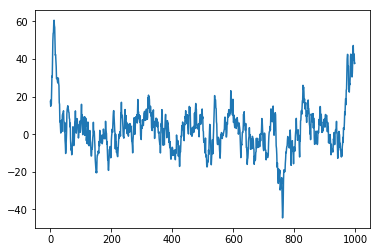

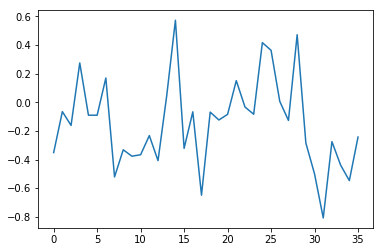

torch.Size([1775, 4])
Train Accuracy: 40 %


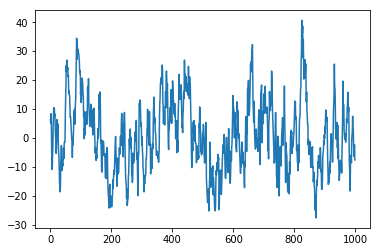

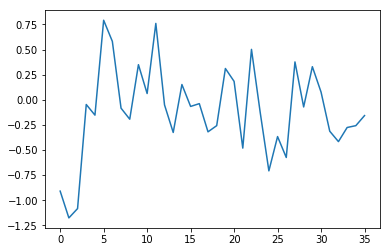

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 33 %
Epoch [14/20], Iter [1/17] Loss: [----- 1.8778 = 1.1884 + 1.00 * 0.3711 + 0.01 * 31.8291 -----]
Epoch [14/20], Iter [2/17] Loss: [----- 2.0364 = 1.1257 + 1.00 * 0.5925 + 0.01 * 31.8123 -----]
Epoch [14/20], Iter [3/17] Loss: [----- 3.0693 = 1.1638 + 1.00 * 1.5875 + 0.01 * 31.7973 -----]
Epoch [14/20], Iter [4/17] Loss: [----- 6.6580 = 1.2157 + 1.00 * 5.1245 + 0.01 * 31.7824 -----]
Epoch [14/20], Iter [5/17] Loss: [----- 3.2855 = 1.2546 + 1.00 * 1.7132 + 0.01 * 31.7671 -----]
Epoch [14/20], Iter [6/17] Loss: [----- 6.0647 = 1.2233 + 1.00 * 4.5238 + 0.01 * 31.7527 -----]
Epoch [14/20], Iter [7/17] Loss: [----- 1.9941 = 1.2076 + 1.00 * 0.4692 + 0.01 * 31.7372 -----]
Epoch [14/20], Iter [8/17] Loss: [----- 12.8362 = 1.2232 + 1.00 * 11.2958 + 0.01 * 31.7223 -----]
Epoch [14/20], Iter [9/17] Loss: [----- 2.9569 = 1.2357 + 1.00 * 1.4041 + 0.01 * 31.7065 -----]
Epoch [14/20], Iter [10/17] Loss: [----- 2.8182 = 1.2655 + 1.00 

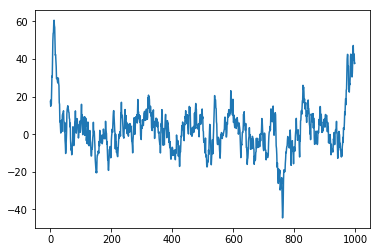

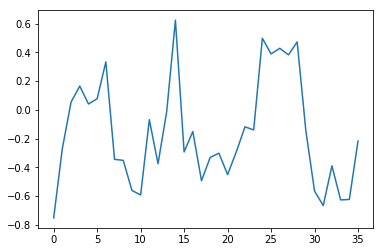

torch.Size([1775, 4])
Train Accuracy: 42 %


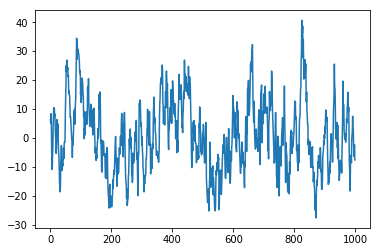

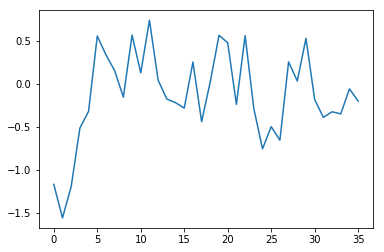

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 36 %
Epoch [15/20], Iter [1/17] Loss: [----- 2.1333 = 1.0989 + 1.00 * 0.7191 + 0.01 * 31.5303 -----]
Epoch [15/20], Iter [2/17] Loss: [----- 7.8560 = 1.2108 + 1.00 * 6.3300 + 0.01 * 31.5164 -----]
Epoch [15/20], Iter [3/17] Loss: [----- 1.5403 = 1.1582 + 1.00 * 0.0671 + 0.01 * 31.5020 -----]
Epoch [15/20], Iter [4/17] Loss: [----- 1.7301 = 1.1109 + 1.00 * 0.3043 + 0.01 * 31.4879 -----]
Epoch [15/20], Iter [5/17] Loss: [----- 1.6135 = 1.1665 + 1.00 * 0.1322 + 0.01 * 31.4741 -----]
Epoch [15/20], Iter [6/17] Loss: [----- 1.9406 = 1.2158 + 1.00 * 0.4102 + 0.01 * 31.4617 -----]
Epoch [15/20], Iter [7/17] Loss: [----- 2.1783 = 1.2109 + 1.00 * 0.6530 + 0.01 * 31.4491 -----]
Epoch [15/20], Iter [8/17] Loss: [----- 1.8573 = 1.1657 + 1.00 * 0.3772 + 0.01 * 31.4365 -----]
Epoch [15/20], Iter [9/17] Loss: [----- 3.6224 = 1.2459 + 1.00 * 2.0623 + 0.01 * 31.4238 -----]
Epoch [15/20], Iter [10/17] Loss: [----- 1.9136 = 1.1499 + 1.00 * 

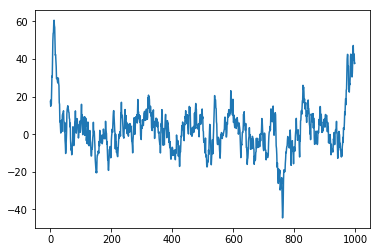

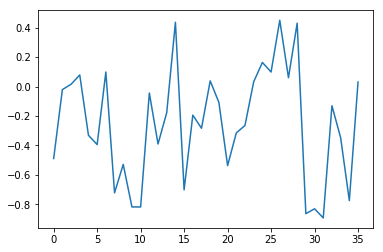

torch.Size([1775, 4])
Train Accuracy: 39 %


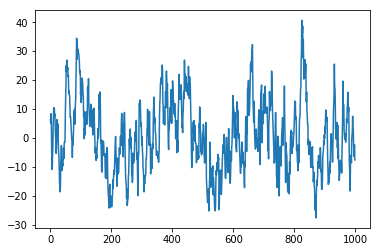

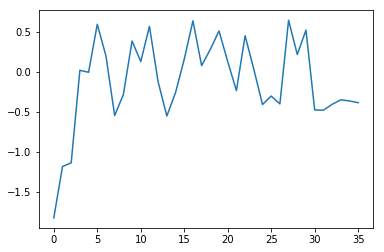

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 36 %
Epoch [16/20], Iter [1/17] Loss: [----- 14.4552 = 1.1309 + 1.00 * 13.0113 + 0.01 * 31.3032 -----]
Epoch [16/20], Iter [2/17] Loss: [----- 3.9941 = 1.3199 + 1.00 * 2.3614 + 0.01 * 31.2887 -----]
Epoch [16/20], Iter [3/17] Loss: [----- 5.5876 = 1.2794 + 1.00 * 3.9955 + 0.01 * 31.2732 -----]
Epoch [16/20], Iter [4/17] Loss: [----- 2.1985 = 1.2211 + 1.00 * 0.6648 + 0.01 * 31.2569 -----]
Epoch [16/20], Iter [5/17] Loss: [----- 2.4719 = 1.2877 + 1.00 * 0.8719 + 0.01 * 31.2415 -----]
Epoch [16/20], Iter [6/17] Loss: [----- 3.9849 = 1.2047 + 1.00 * 2.4679 + 0.01 * 31.2255 -----]
Epoch [16/20], Iter [7/17] Loss: [----- 1.4913 = 1.1452 + 1.00 * 0.0340 + 0.01 * 31.2115 -----]
Epoch [16/20], Iter [8/17] Loss: [----- 1.7618 = 1.1903 + 1.00 * 0.2594 + 0.01 * 31.1989 -----]
Epoch [16/20], Iter [9/17] Loss: [----- 1.5442 = 1.2032 + 1.00 * 0.0291 + 0.01 * 31.1861 -----]
Epoch [16/20], Iter [10/17] Loss: [----- 7.4372 = 1.1486 + 1.00 

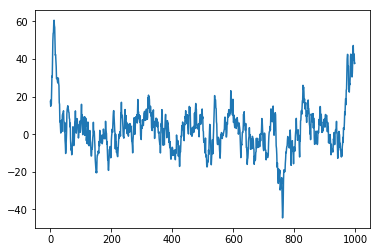

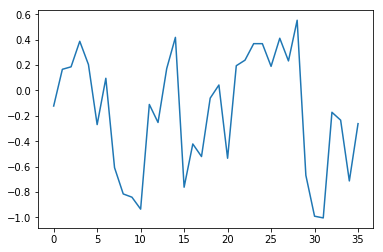

torch.Size([1775, 4])
Train Accuracy: 44 %


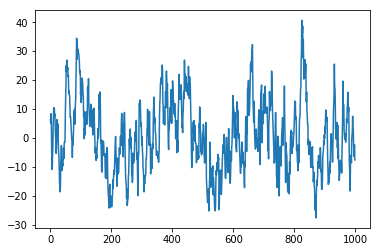

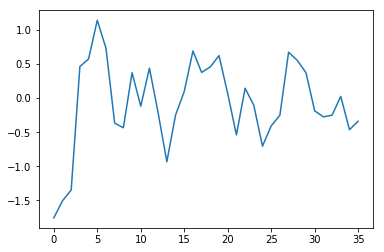

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 42 %
Epoch [17/20], Iter [1/17] Loss: [----- 1.7197 = 1.1819 + 1.00 * 0.2273 + 0.01 * 31.0494 -----]
Epoch [17/20], Iter [2/17] Loss: [----- 1.6679 = 1.1802 + 1.00 * 0.1773 + 0.01 * 31.0346 -----]
Epoch [17/20], Iter [3/17] Loss: [----- 2.3038 = 1.1365 + 1.00 * 0.8570 + 0.01 * 31.0205 -----]
Epoch [17/20], Iter [4/17] Loss: [----- 1.8863 = 1.2716 + 1.00 * 0.3046 + 0.01 * 31.0072 -----]
Epoch [17/20], Iter [5/17] Loss: [----- 1.6283 = 1.1105 + 1.00 * 0.2078 + 0.01 * 30.9931 -----]
Epoch [17/20], Iter [6/17] Loss: [----- 1.6406 = 1.1929 + 1.00 * 0.1379 + 0.01 * 30.9807 -----]
Epoch [17/20], Iter [7/17] Loss: [----- 2.1144 = 1.0724 + 1.00 * 0.7323 + 0.01 * 30.9689 -----]
Epoch [17/20], Iter [8/17] Loss: [----- 1.9534 = 1.1264 + 1.00 * 0.5174 + 0.01 * 30.9587 -----]
Epoch [17/20], Iter [9/17] Loss: [----- 1.8156 = 1.2112 + 1.00 * 0.2949 + 0.01 * 30.9503 -----]
Epoch [17/20], Iter [10/17] Loss: [----- 1.6703 = 1.1269 + 1.00 * 

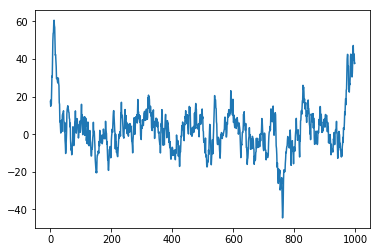

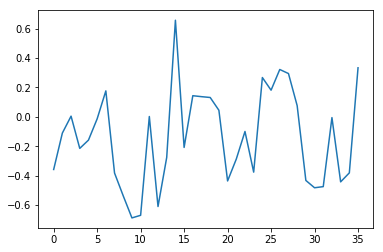

torch.Size([1775, 4])
Train Accuracy: 48 %


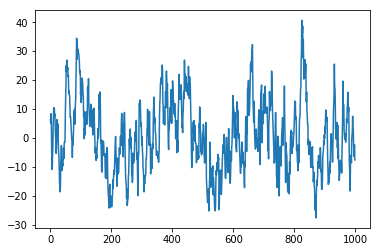

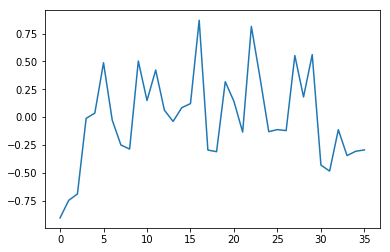

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 39 %
Epoch [18/20], Iter [1/17] Loss: [----- 1.5840 = 1.1415 + 1.00 * 0.1341 + 0.01 * 30.8390 -----]
Epoch [18/20], Iter [2/17] Loss: [----- 1.8553 = 1.1494 + 1.00 * 0.3977 + 0.01 * 30.8257 -----]
Epoch [18/20], Iter [3/17] Loss: [----- 3.6867 = 1.1588 + 1.00 * 2.2198 + 0.01 * 30.8141 -----]
Epoch [18/20], Iter [4/17] Loss: [----- 3.2146 = 1.0455 + 1.00 * 1.8611 + 0.01 * 30.8034 -----]
Epoch [18/20], Iter [5/17] Loss: [----- 19.7304 = 1.1818 + 1.00 * 18.2408 + 0.01 * 30.7921 -----]
Epoch [18/20], Iter [6/17] Loss: [----- 5.4831 = 1.1333 + 1.00 * 4.0420 + 0.01 * 30.7802 -----]
Epoch [18/20], Iter [7/17] Loss: [----- 2.0550 = 1.2413 + 1.00 * 0.5060 + 0.01 * 30.7677 -----]
Epoch [18/20], Iter [8/17] Loss: [----- 1.5210 = 1.1412 + 1.00 * 0.0723 + 0.01 * 30.7535 -----]
Epoch [18/20], Iter [9/17] Loss: [----- 2.1222 = 1.1531 + 1.00 * 0.6616 + 0.01 * 30.7388 -----]
Epoch [18/20], Iter [10/17] Loss: [----- 2.0270 = 1.2336 + 1.00 

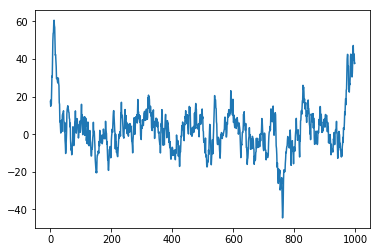

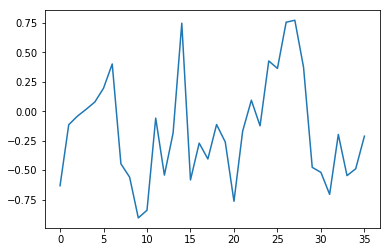

torch.Size([1775, 4])
Train Accuracy: 46 %


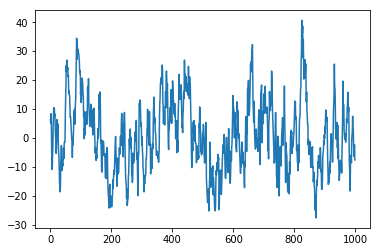

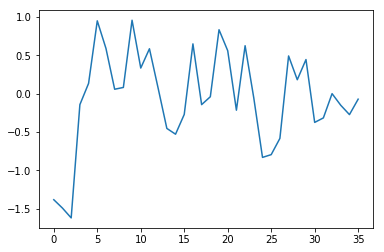

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 42 %
Epoch [19/20], Iter [1/17] Loss: [----- 27.3658 = 1.1588 + 1.00 * 25.9009 + 0.01 * 30.6128 -----]
Epoch [19/20], Iter [2/17] Loss: [----- 1.5998 = 1.1337 + 1.00 * 0.1600 + 0.01 * 30.5988 -----]
Epoch [19/20], Iter [3/17] Loss: [----- 1.5565 = 1.1648 + 1.00 * 0.0859 + 0.01 * 30.5840 -----]
Epoch [19/20], Iter [4/17] Loss: [----- 2.2530 = 1.1674 + 1.00 * 0.7799 + 0.01 * 30.5702 -----]
Epoch [19/20], Iter [5/17] Loss: [----- 1.5545 = 1.1376 + 1.00 * 0.1113 + 0.01 * 30.5581 -----]
Epoch [19/20], Iter [6/17] Loss: [----- 1.5821 = 1.1431 + 1.00 * 0.1335 + 0.01 * 30.5471 -----]


In [ ]:
import gc
gc.collect()

torch.manual_seed(1111)

train_acc = []
val_acc = []
loss_history = []
          
for epoch in range(num_epochs):

    ######################## TRAINING
        
    net.train(True)
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
        
        if (VERBOSE):
            print('initial label shape: {}'.format(labels.shape))
            
        labels = Variable(labels)

        if (VERBOSE):
            print('iteration label set {}'.format(np.unique(labels.data)))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        
        if (FCC_SANITY):
            outputs = net(images)
        else:    
            outputs, hidden = net(images)

        _, predicted = torch.max(outputs.data, 1)
    
        if (VERBOSE):
            print('training predicted set {}'.format(np.unique(predicted.data)))
            print('training output shape: {}'.format(outputs.shape))
            print('training labels shape: {}'.format(labels.shape))
        
        loss1 = criterion(outputs, labels)
        loss1.backward(retain_graph=True)
        
        ## hidden state vanishing gradient regularizer
        hidden_loss, size_loss = net.loss_regularizer()
        
        ## general weight l2 regularizer()
        
        loss = loss1 + reg_hidden_weight*hidden_loss + reg_weight_size*size_loss

        #loss = criterion(outputs, labels)

        loss_history.append(loss)
        loss.backward()
        
        nn.utils.clip_grad_norm(net.parameters(), 100)
        optimizer.step()
        
        print ('Epoch [%d/%d], Iter [%d/%d] Loss: [----- %.4f = %.4f + %.2f * %.4f + %.2f * %.4f -----]' 
               %(epoch+1, num_epochs, i+1, rnn_training_data_X.shape[0]*1.0/batch_size,
                 loss.data[0], loss1.data[0],
                 reg_hidden_weight, hidden_loss.data[0],
                 reg_weight_size, size_loss.data[0]))
    
    ######################## PER EPOCH EVALUATION
            
    bad_grads = []
    for n,p in net.named_parameters():
        grad_max = torch.max(p.grad)
        abs_grad_mean = torch.mean(torch.abs(p.grad))
        if (PRINT_GRADS):
            print('===========\ngradient:{}'.format(n))
            print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))
            
        stats = [n, grad_max, abs_grad_mean]
        
        if (abs_grad_mean < 1e-4):
            stats.append('SMALL')
            bad_grads.append(stats)
        elif (1 < abs_grad_mean):
            stats.append('BIG')
            bad_grads.append(stats)
            
    for n, grad_max, abs_grad_mean, descr in bad_grads:
        print('===========\n {} gradient:{}'.format(descr, n))
        print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))  
        
    if (VERBOSE):
        print('weight_hh_l0:')
        print(net.rnn_layer.state_dict()['weight_hh_l0'])

    
    net.train(False)
    
    images = Variable(torch.Tensor(rnn_training_data_X))
    test_labels = torch.LongTensor(rnn_training_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    print(outputs.shape)
    
    correct = 0
    total = 0
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('Train Accuracy: %d %%' % (100 * int(correct) / float(total)))
    train_acc.append((100 * correct / total))

    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    images = Variable(torch.Tensor(rnn_validation_data_X))
    test_labels = torch.LongTensor(rnn_validation_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    print('predicted set {}'.format(np.unique(predicted.data)))
    print('label set {}'.format(np.unique(test_labels.data)))
    
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('validation Accuracy: %d %%' % (100.0 * int(correct) / float(total)))
    val_acc.append((100 * correct / total))

In [ ]:
l = list(net.layer1.modules())
print(l[1].running_mean)
print(l[1].running_var)